In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

import emcee
#import pymc3
import corner

#import dynesty

import sklearn
from sklearn import manifold
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift

# Dimensional reduction
from sklearn.decomposition import PCA

# Cross validation
from sklearn.model_selection import GridSearchCV

## Fun with Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



#### Python tip. Web request and smarter file reading

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [3]:
names # data structure names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
# import variables

# burst duration -> unit: seconds

T90 = np.array(data[names=='T90'][0],dtype=float)
T90_err = np.array(data[names=='T90_error'][0],dtype=float)

#redshift
z = np.array(data[names=='redshift'][0],dtype=float)

# time integrated total energy per unit surface -> unit: erg/cm^2
fluence = np.array(data[names=='fluence'][0],dtype=float)
fluence_err = np.array(data[names=='fluence_error'][0],dtype=float)

# positions:
ra = np.array(data[names=='ra'][0],dtype=float)
dec = np.array(data[names=='decl'][0],dtype=float)

# mask the real data without -999
mask_real_data = (T90!=-999) & (fluence!=-999) #& (z!=-999)

T90_log = np.log10(T90[mask_real_data])
fluence_log = np.log10(fluence[mask_real_data])
z_log = np.log10(z[mask_real_data])

<ipython-input-4-fab6b6ad5838>:23: RuntimeWarning: divide by zero encountered in log10
  fluence_log = np.log10(fluence[mask_real_data])
<ipython-input-4-fab6b6ad5838>:24: RuntimeWarning: invalid value encountered in log10
  z_log = np.log10(z[mask_real_data])


### Single component analysis

Text(0.5, 1.0, 'Fluence vs redshift')

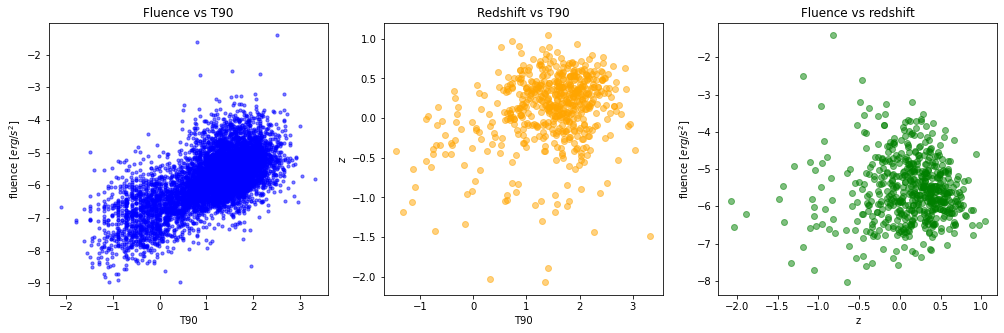

In [5]:
# mask log 
mask_log = (T90_log!=-np.inf) & (fluence_log!=-np.inf)# & (z_log!=-np.inf)

T90_use = T90_log[mask_log]
fluence_use = fluence_log[mask_log]
z_use = z_log[mask_log]

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(17,5))

ax[0].scatter(T90_use,fluence_use,color='blue',alpha=0.5,s=10)
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence $[erg/s^2]$')
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_title('Fluence vs T90')

ax[1].scatter(T90_use,z_use,color='orange',alpha=0.5)
ax[1].set_xlabel('T90')
ax[1].set_ylabel('$z$')
#ax[1].set_yscale('log')
#ax[1].set_xscale('log')
ax[1].set_title('Redshift vs T90')

ax[2].scatter(z_use,fluence_use,color='green',alpha=0.5)
ax[2].set_xlabel('z')
ax[2].set_ylabel('fluence $[erg/s^2]$')
#ax[2].set_yscale('log')
#ax[2].set_xscale('log')
ax[2].set_title('Fluence vs redshift')

We can distinguish two separated populations in the Fluence vs T90 plot. So I will focus on this two variables.

### Fluence vs T90

#### Kmeans

Text(0, 0.5, 'fluence')

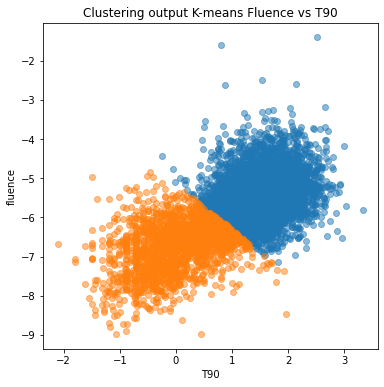

In [6]:
# K-means

X_T90_F = np.array([T90_use,fluence_use]).T

clf = KMeans(n_clusters=2)
clf.fit(X_T90_F)
labels = clf.predict(X_T90_F) #labels for each of the points

fig = plt.figure(figsize=(6,6))
# plot the data color-coded by cluster id
for ii in range(int(labels.max())+1):
    plt.scatter(X_T90_F[labels==ii,0], X_T90_F[labels==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output K-means Fluence vs T90')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('fluence')

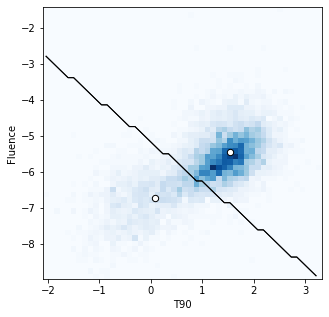

In [7]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

n_clusters = labels.max()+1

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_T90_F[:,0], X_T90_F[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = clf.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()

#### Meanshift

Number of clusters identified: 22


Text(0, 0.5, 'fluence')

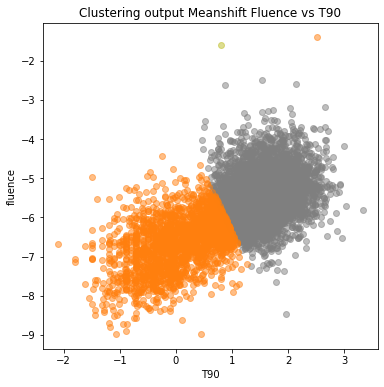

In [8]:
# Meanshift 

scaler = preprocessing.StandardScaler()
bw = 0.4

ms = MeanShift(bandwidth=bw,cluster_all=True,bin_seeding=True)

ms.fit(scaler.fit_transform(X_T90_F))

labels_T90_F = ms.predict(X_T90_F)
print('Number of clusters identified:',labels_T90_F.max()+1)

fig = plt.figure(figsize=(6,6))

for ii in range(int(labels_T90_F.max())+1):
    plt.scatter(X_T90_F[labels_T90_F==ii,0], X_T90_F[labels_T90_F==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift Fluence vs T90')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('fluence')

<ipython-input-13-717390178523>:37: UserWarning: No contour levels were found within the data range.
  ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')
<ipython-input-13-717390178523>:37: UserWarning: No contour levels were found within the data range.
  ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')
<ipython-input-13-717390178523>:37: UserWarning: No contour levels were found within the data range.
  ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')
<ipython-input-13-717390178523>:37: UserWarning: No contour levels were found within the data range.
  ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')
<ipython-input-13-717390178523>:37: UserWarning: No contour levels were found within the data range.
  ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')
<ipython-input-13-717390178523>:37: UserWarning: No contour levels were found within the data range.
  ax

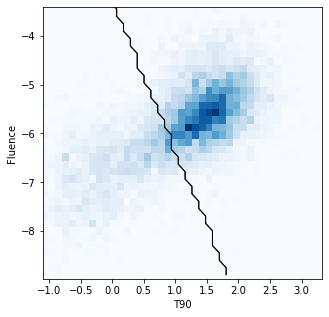

In [13]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

n_clusters = labels_T90_F.max()+1

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_T90_F[:,0], X_T90_F[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = ms.cluster_centers_
#for i in range(n_clusters):
    #ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],s=40, c='w', edgecolors='k')
    

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')

    H = ms.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0]+1, xedges[-1])
ax.set_ylim(yedges[0], yedges[-1]-2)

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()

# Stuff

### PCA approach

In [6]:
# define the array
X = np.vstack([T90_use,fluence_use,z_use]).T
X.shape

(565, 3)

(0.1, 10000)

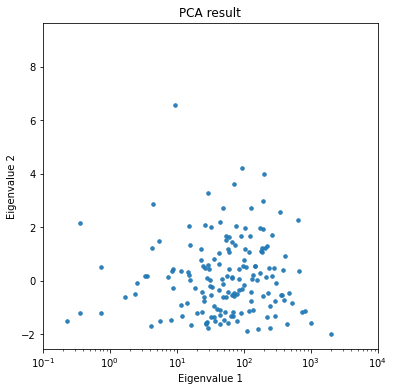

In [7]:
# try to reduce the dimensionality of the problem to two variables:

pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting

X_reduced = pca.transform(X) # reduce to 2-dim

fig = plt.figure(figsize=(6,6))

plt.scatter(X_reduced[:,0], X_reduced[:,1], s=50,
            marker=".", color='C0', 
            alpha=0.9)

plt.title('PCA result')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
plt.xscale('log')
plt.xlim(0.1,10000)

In [8]:
X_reduced.shape

(565, 2)

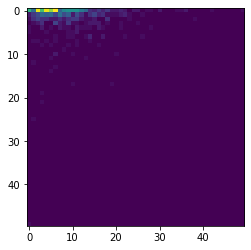

In [9]:
histo2D,xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

plt.imshow(histo2D)

(0.1, 10000)

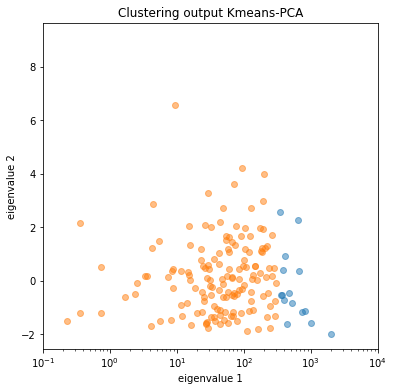

In [10]:
# K-MEANS clustering

clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X_reduced)
labels = clf.predict(X_reduced) #labels for each of the points

fig = plt.figure(figsize=(6,6))

# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X_reduced[labels==ii,0], X_reduced[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output Kmeans-PCA')
plt.xscale('log')
plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')
plt.xlim(0.1,10000)

(0.1, 10000)

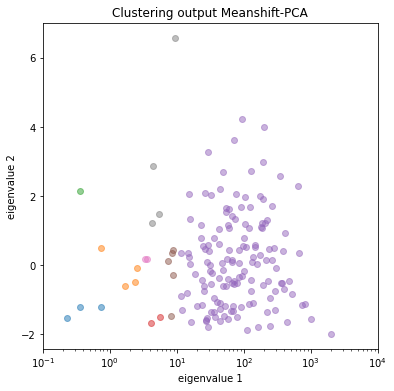

In [11]:
# MEAN-shift clustering
scaler = preprocessing.StandardScaler()
#bandwidth = 0.4
bandwidth = sklearn.cluster.estimate_bandwidth(X_reduced)

#ms = MeanShift(bandwidth=bandwidth,bin_seeding=False, cluster_all=True)
ms = MeanShift()

ms.fit(scaler.fit_transform(X_reduced))

labels = ms.predict(X_reduced)

fig = plt.figure(figsize=(6,6))

# plot the data color-coded by cluster id

for ii in range(int(labels.max())):
    plt.scatter(X_reduced[labels==ii,0], X_reduced[labels==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift-PCA')
plt.xscale('log')
plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')
plt.xlim(0.1,10000)

Better an analysis on the single variables!

### Single variable-variable analysis

In [14]:
idx_T90_F = labels_T90_F==scipy.stats.mode(labels_T90_F)[0] # indices of the sources belonging to the most populated cluster

In [15]:
idx_T90_F.shape

(565,)

### Redshift vs T90

Text(0, 0.5, 'z')

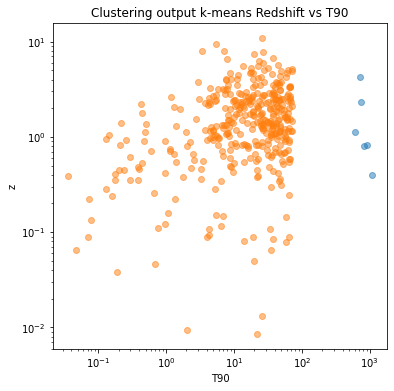

In [16]:
X_T90_z = np.array([T90_use,z_use]).T

clf = KMeans(n_clusters=5) 
clf.fit(X_T90_z)
labels = clf.predict(X_T90_z) #labels for each of the points

fig = plt.figure(figsize=(6,6))
# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X_T90_z[labels==ii,0], X_T90_z[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output k-means Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('z')

Number of clusters identified: 9


Text(0, 0.5, 'z')

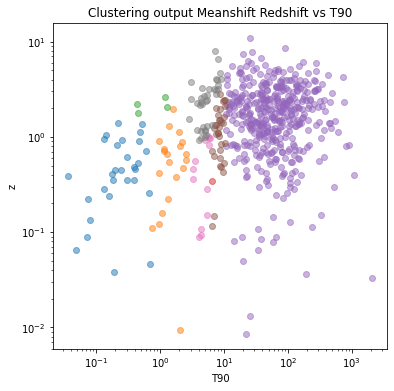

In [17]:
# Meanshift 

scaler = preprocessing.StandardScaler()
#bandwidth = 0.4

ms = MeanShift(cluster_all=True)

ms.fit(scaler.fit_transform(X_T90_z))

labels_T90_z = ms.predict(X_T90_z)
print('Number of clusters identified:',labels_T90_z.max()+1)

fig = plt.figure(figsize=(6,6))

for ii in range(int(labels_T90_z.max())):
    plt.scatter(X_T90_z[labels_T90_z==ii,0], X_T90_z[labels_T90_z==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('z')

In [18]:
idx_T90_z = labels_T90_z==scipy.stats.mode(labels_T90_z)[0] # indices of the sources belonging to the most populated cluster

In [19]:
len(idx_T90_z)

565

### Fluence vs Redshift

Text(0.5, 0, 'z')

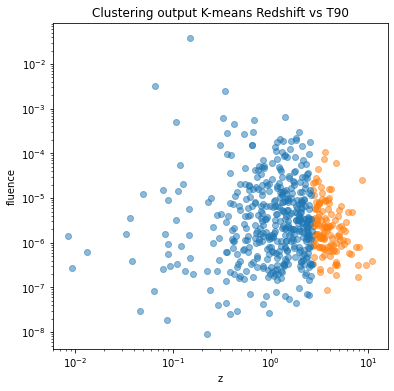

In [20]:
X_z_fluence = np.array([z_use,fluence_use]).T

clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X_z_fluence)
labels = clf.predict(X_z_fluence) #labels for each of the points

fig = plt.figure(figsize=(6,6))
# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X_z_fluence[labels==ii,0], X_z_fluence[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output K-means Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('fluence')
plt.xlabel('z')

Number of clusters identified: 4


Text(0.5, 0, 'z')

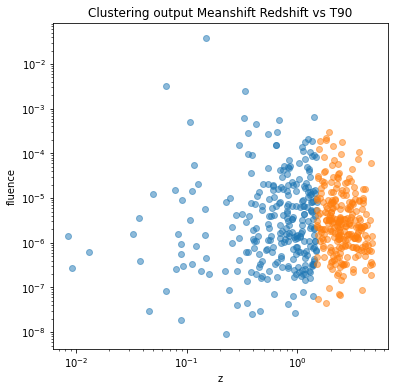

In [21]:
# Meanshift 

scaler = preprocessing.StandardScaler()
#bandwidth = 0.4

ms = MeanShift(cluster_all=True)

ms.fit(scaler.fit_transform(X_z_fluence))

labels = ms.predict(X_z_fluence)
print('Number of clusters identified:',labels.max()+1)

fig = plt.figure(figsize=(6,6))

for ii in range(int(labels.max())):
    plt.scatter(X_z_fluence[labels==ii,0], X_z_fluence[labels==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('fluence')
plt.xlabel('z')

### Results data analysis

Check if the most populated cluster are consistent between F vs T90 and F vs redshift

In [22]:
# find where the two identified population differs
idx_comparison = np.where((idx_T90_F==idx_T90_z))[0]

print("The main population has been identified with the %.3f of accuracy"%(len(idx_comparison)/len(idx_T90_F)) )

The main population has been identified with the 0.998 of accuracy


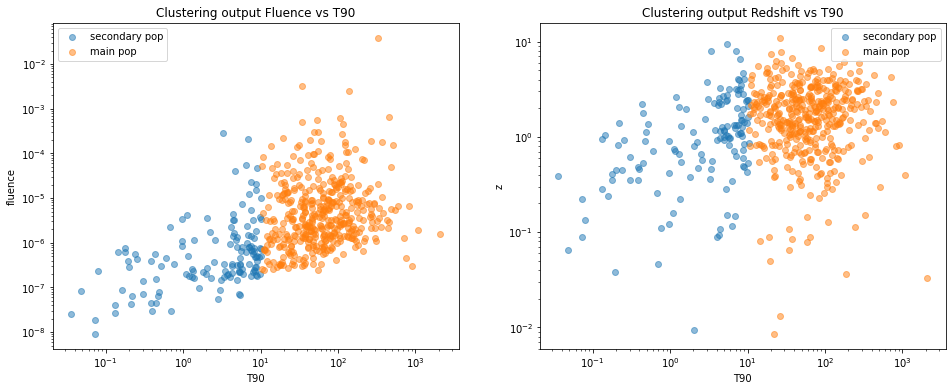

In [40]:
# build two different populations:

# fluence vs T90:
labels_pop_F = np.zeros(X_T90_F.shape[0],dtype=int)
labels_pop_F[idx_T90_F==True] = int(1)

# redshift vs T90
labels_pop_z = np.zeros(X_T90_z.shape[0],dtype=int)
labels_pop_z[idx_T90_z==True] = int(1)

# plot the results:

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

label = ['secondary pop','main pop']
for ii in range(2):
    ax[0].scatter(X_T90_F[labels_pop_F==ii,0], X_T90_F[labels_pop_F==ii,1],color='C%i'%ii,alpha=0.5,label=label[ii])
    ax[1].scatter(X_T90_z[labels_pop_z==ii,0], X_T90_z[labels_pop_z==ii,1],color='C%i'%ii,alpha=0.5,label=label[ii])
    
ax[0].set_title('Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
ax[0].legend()

ax[1].set_title('Clustering output Redshift vs T90')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('T90')
ax[1].set_ylabel('z')
ax[1].legend()

### Try with all the features together

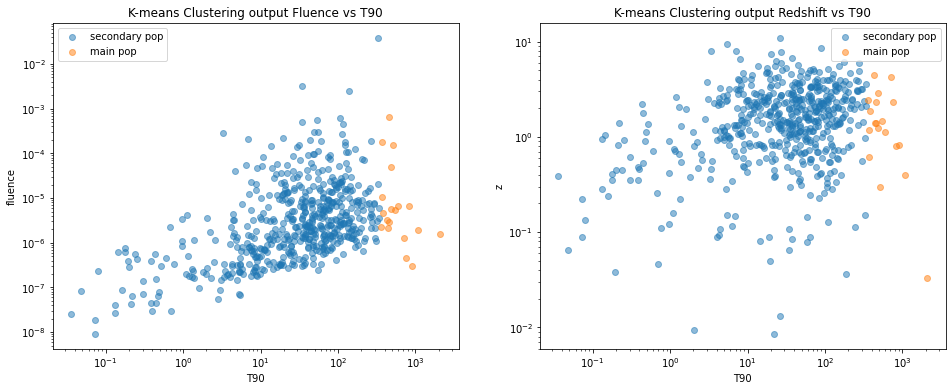

In [70]:
# K-means
clf = KMeans(n_clusters=2)
clf.fit(X)
labels = clf.predict(X) #labels for each of the points

# plot with projection on two axis

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

label = ['secondary pop','main pop']
for ii in range(2):
    ax[0].scatter(X[:,0][labels==ii], X[:,1][labels==ii],color='C%i'%ii,alpha=0.5,label=label[ii])
    ax[1].scatter(X[:,0][labels==ii], X[:,2][labels==ii],color='C%i'%ii,alpha=0.5,label=label[ii])
    
ax[0].set_title('K-means Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
ax[0].legend()

ax[1].set_title('K-means Clustering output Redshift vs T90')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('T90')
ax[1].set_ylabel('z')
ax[1].legend()

Number of clusters identified: 10


Text(0, 0.5, 'z')

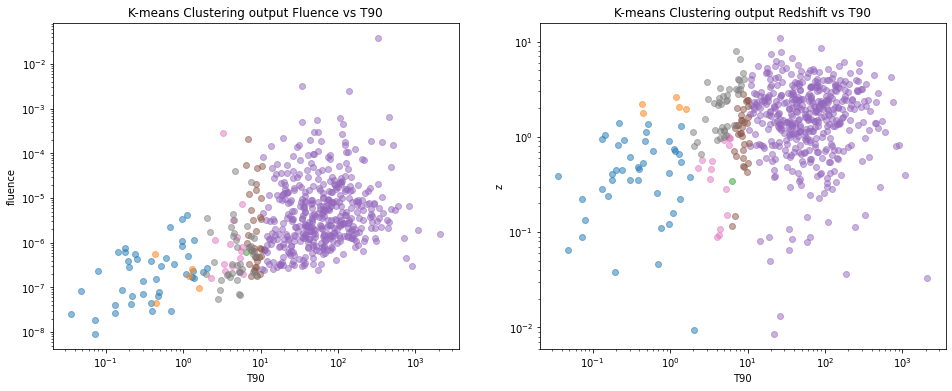

In [68]:
# Meanshift

scaler = preprocessing.StandardScaler()
#bandwidth = 0.4

ms = MeanShift(cluster_all=True)

ms.fit(scaler.fit_transform(X))

labels = ms.predict(X)
print('Number of clusters identified:',labels.max()+1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

for ii in range(labels.max()):
    ax[0].scatter(X[:,0][labels==ii], X[:,1][labels==ii],color='C%i'%ii,alpha=0.5)
    ax[1].scatter(X[:,0][labels==ii], X[:,2][labels==ii],color='C%i'%ii,alpha=0.5)
    
ax[0].set_title('K-means Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
#ax[0].legend()

ax[1].set_title('K-means Clustering output Redshift vs T90')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('T90')
ax[1].set_ylabel('z')
#ax[1].legend()

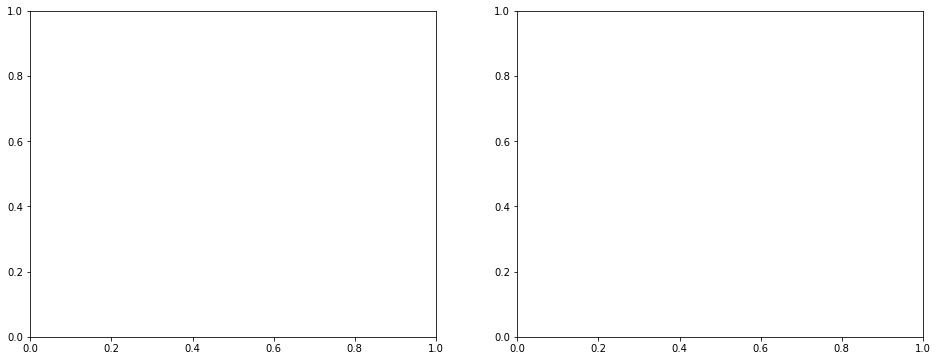

In [45]:
# plot with boundaries:

fig = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

# Compute a 2D histogram  of the input
H_F, xedges_F, yedges_F = np.histogram2d(X_T90_F[:,0], X_T90_F[:,1], 50)

# plot density
ax[0].imshow(H_F.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges_F[0], xedges_F[-1],
                  yedges_F[0], yedges_F[-1]],
          cmap='Blues')

# plot cluster centers
#cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
#ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],s=40, c='w', edgecolors='k')

ax[0].set_title('Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
ax[0].legend()

In [ ]:
# plot cluster boundaries
x_centers_F = 0.5 * (xedges_F[1:] + xedges_F[:-1])
y_centers_F = 0.5 * (yedges_F[1:] + yedges_F[:-1])

Xgrid_F = np.meshgrid(x_centers_F, y_centers_F)
Xgrid_F = np.array(Xgrid_F).reshape((2, 50 * 50)).T

H_F = ms.predict(scaler.transform(Xgrid_F)).reshape((50, 50))

for i in range(2):
    Hcp = H_F.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax[0].contour(x_centers_F, y_centers_F, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H_F = ms.predict(scaler.transform(Xgrid_F)).reshape((50, 50))
    
ax[0].set_xlim(xedges_F[0], xedges_F[-1])
ax[0].set_ylim(yedges_F[0], yedges_F[-1])

ax[0].set_xlabel('Eigenvalue 1')
ax[0].set_ylabel('Eigenvalue 2')

plt.show()